In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import torch

torch.cuda.is_available() 

False

In [ ]:
import pandas as pd

df = pd.read_csv('NFLX.csv')
df = df[['Close']].dropna()

close_real_prices = df.values
print(df)

           Close
0     254.259995
1     265.720001
2     264.559998
3     250.100006
4     249.470001
...          ...
1004  427.140015
1005  457.130005
1006  429.480011
1007  405.600006
1008  410.170013

[1009 rows x 1 columns]


In [ ]:


def window_df(df, n):
    windowed_df = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_df[f'Target-{i}'] = df['Close'].shift(i)
    windowed_df['Target'] = df['Close']
    return windowed_df.dropna()

window = 125
df_window = window_df(df, window)

C:\Users\mikol\AppData\Local\Temp\ipykernel_11008\4200158628.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windowed_df[f'Target-{i}'] = df['Close'].shift(i)
C:\Users\mikol\AppData\Local\Temp\ipykernel_11008\4200158628.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windowed_df[f'Target-{i}'] = df['Close'].shift(i)
C:\Users\mikol\AppData\Local\Temp\ipykernel_11008\4200158628.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [ ]:

# load the dataset

dataset = df.values
dataset = dataset.astype('float32')

In [ ]:

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.79)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

797 212


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:

# reshape into X=t and Y=t+1
look_back = window
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX.shape)

(86, 125)


In [ ]:

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))

testX = np.reshape(testX, (testX.shape[0],testX.shape[1] , 1))


testX.shape

(86, 125, 1)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

NameError: name 'jit' is not defined

In [ ]:
input_shape = trainX.shape[1:]

model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55,  # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=4,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"]
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]


model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
)

model.evaluate(testX, testY, verbose=1)

Epoch 1/100
42/42 [==============================] - 46s 1s/step - loss: 0.1426 - mean_squared_error: 0.1426
Epoch 2/100
42/42 [==============================] - 44s 1s/step - loss: 0.0418 - mean_squared_error: 0.0418
Epoch 3/100
42/42 [==============================] - 43s 1s/step - loss: 0.0377 - mean_squared_error: 0.0377
Epoch 4/100
42/42 [==============================] - 50s 1s/step - loss: 0.0311 - mean_squared_error: 0.0311
Epoch 5/100
42/42 [==============================] - 46s 1s/step - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 6/100
42/42 [==============================] - 47s 1s/step - loss: 0.0230 - mean_squared_error: 0.0230
Epoch 7/100
42/42 [==============================] - 47s 1s/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 8/100
42/42 [==============================] - 46s 1s/step - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 9/100
42/42 [==============================] - 46s 1s/step - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 10/100
42/42 

[0.017206519842147827, 0.017206519842147827]

In [ ]:
from sklearn import metrics

pred = model.predict(testX)
score = np.sqrt(metrics.mean_squared_error(pred,testY))
print("Score (RMSE): {}".format(score))



3/3 [==============================] - 3s 747ms/step
Score (RMSE): 0.13117361068725586


In [ ]:
print(pred)

[[0.8252802 ]
 [0.8199396 ]
 [0.8404309 ]
 [0.8463422 ]
 [0.85202307]
 [0.87166446]
 [0.8710034 ]
 [0.85412467]
 [0.8629804 ]
 [0.8742181 ]
 [0.8783227 ]
 [0.8785439 ]
 [0.8757877 ]
 [0.87663776]
 [0.9004209 ]
 [0.9114223 ]
 [0.92881894]
 [0.9384322 ]
 [0.93626297]
 [0.9471905 ]
 [0.96057713]
 [0.96548843]
 [0.9736283 ]
 [0.98482364]
 [0.9784756 ]
 [0.9708954 ]
 [0.9571897 ]
 [0.9540388 ]
 [0.9458715 ]
 [0.9518747 ]
 [0.96877646]
 [0.97946334]
 [0.99127567]
 [0.99101126]
 [0.998403  ]
 [0.99825364]
 [0.9861065 ]
 [0.9855312 ]
 [0.98618925]
 [0.9967507 ]
 [0.9860464 ]
 [0.9694408 ]
 [0.9494144 ]
 [0.95040274]
 [0.9372599 ]
 [0.9204358 ]
 [0.9270622 ]
 [0.9383875 ]
 [0.9401304 ]
 [0.9381443 ]
 [0.9163066 ]
 [0.8942019 ]
 [0.89717287]
 [0.9041846 ]
 [0.8799838 ]
 [0.8719703 ]
 [0.88890314]
 [0.8923736 ]
 [0.89576316]
 [0.90688384]
 [0.9038232 ]
 [0.8959097 ]
 [0.89892316]
 [0.89617777]
 [0.88815355]
 [0.88384897]
 [0.8665468 ]
 [0.85463065]
 [0.84008694]
 [0.82622784]
 [0.8056489 ]
 [0.79

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


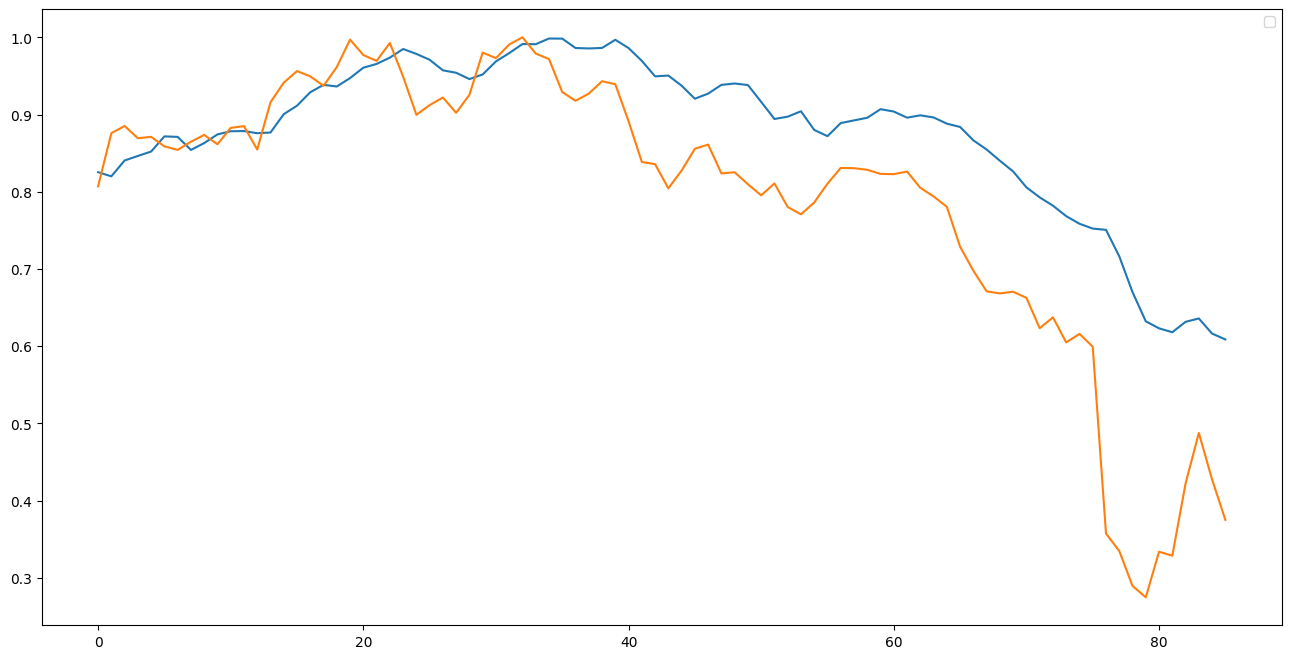

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(pred[:,-1].reshape(-1))

plt.legend()
plt.plot(testY)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
r2 = r2_score(testY, pred[:,-1].reshape(-1))
r2

0.4929456203309285

In [ ]:
testX.shape
predictions = []
latest_prices = trainX
# print(pd.DataFrame(latest_prices[:,:,0]))
print(latest_prices.shape)
general_prediction = model.predict(latest_prices)[-1]

x,y,z = latest_prices.shape
for i in range(len(testY)):
    print(i,' / ',len(testY))
    prediction = model.predict(latest_prices)[-1]
    predictions.append(prediction)


    temp_array = latest_prices[1:,:,:]
    last_row = temp_array[-1,:,:]
    temp_row = np.zeros(last_row.shape)
    
    
    for i in range(y-1):
        temp_row[i][0] = last_row[i+1][0]


    temp_row[-1][0] = prediction

    latest_prices = np.concatenate([latest_prices, temp_row[np.newaxis, :, :]], axis=0)
    

(671, 125, 1)


21/21 [==============================] - 19s 889ms/step
0  /  86
21/21 [==============================] - 18s 865ms/step
1  /  86
21/21 [==============================] - 20s 959ms/step
2  /  86
22/22 [==============================] - 19s 869ms/step
3  /  86
22/22 [==============================] - 19s 847ms/step
4  /  86
22/22 [==============================] - 18s 822ms/step
5  /  86
22/22 [==============================] - 18s 830ms/step
6  /  86
22/22 [==============================] - 18s 825ms/step
7  /  86
22/22 [==============================] - 18s 805ms/step
8  /  86
22/22 [==============================] - 17s 784ms/step
9  /  86
22/22 [==============================] - 17s 782ms/step
10  /  86
22/22 [==============================] - 17s 780ms/step
11  /  86
22/22 [==============================] - 17s 774ms/step
12  /  86
22/22 [==============================] - 17s 774ms/step
13  /  86
22/22 [==============================] - 18s 821ms/step
14  /  86
22/22 [=============

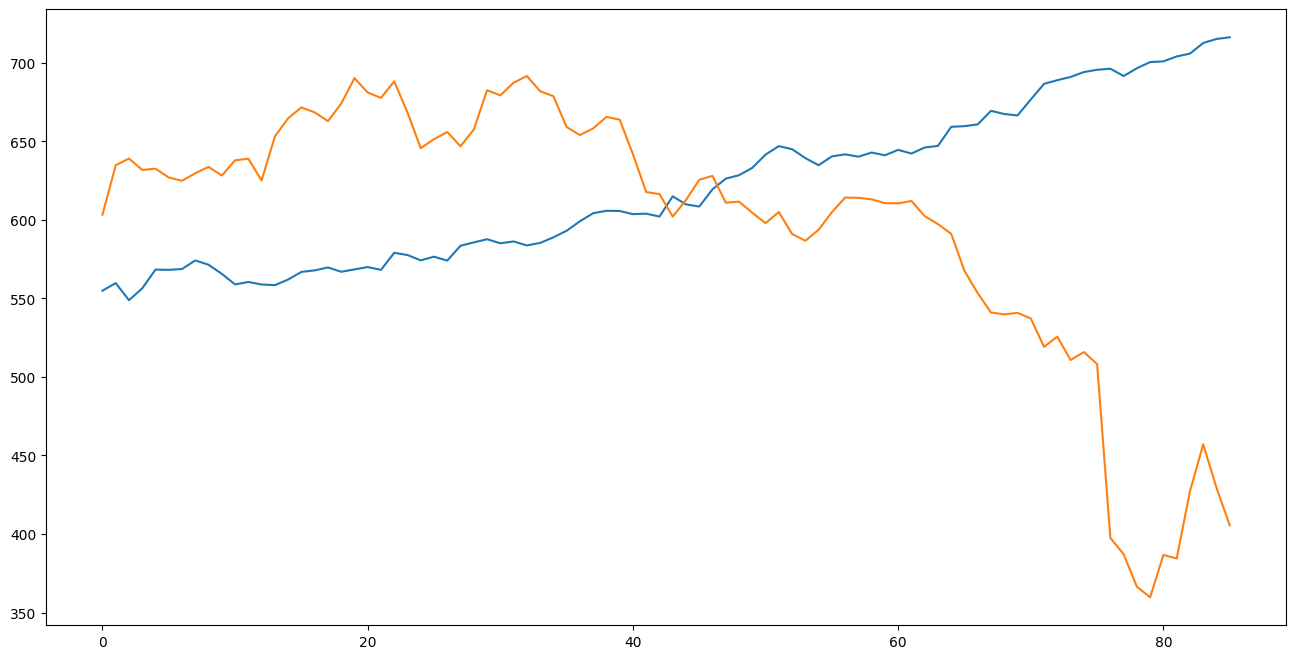

In [ ]:
predictions = scaler.inverse_transform((((np.array(predictions)).reshape(-1))).reshape(-1, 1))
real_prices = scaler.inverse_transform(test.reshape(-1, 1))
sequence_prediction = scaler.inverse_transform(general_prediction.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))
plt.figure(figsize=(16,8))
# plt.plot(sequence_prediction)
plt.plot(predictions)
plt.plot(testY)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(882, 1)


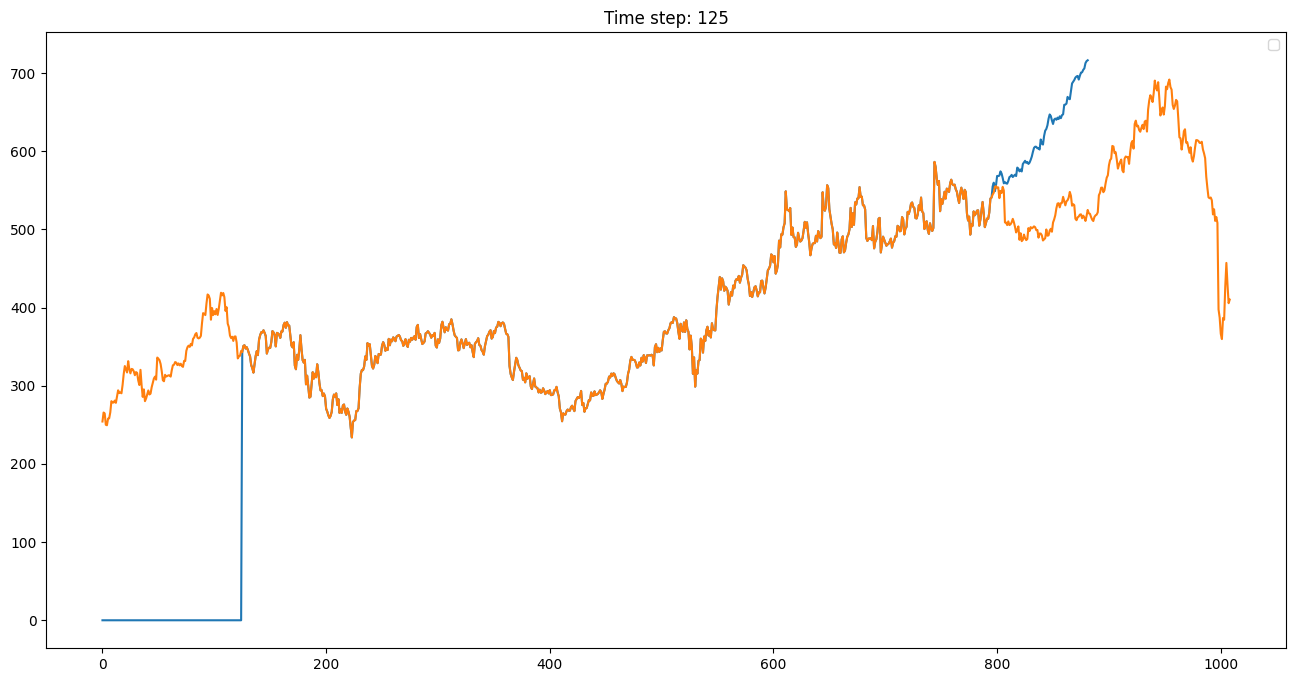

In [ ]:
plt.figure(figsize = (16,8))
empty_array = np.zeros((window,1))

previous_prices = scaler.inverse_transform(trainY.reshape(-1, 1))
previous_prices_vstacked = np.vstack((empty_array,previous_prices,predictions))


print(previous_prices_vstacked.shape)

plt.plot(previous_prices_vstacked)
plt.plot(close_real_prices)

title = "Time step: "+str(window)
plt.title(title)
plt.legend()
plt.show()

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

model.summary()
model.save('models/transformers_window125')

2.12.0
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 125, 1)]     0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 125, 1)      2           ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 125, 1)      19321       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                     

INFO:tensorflow:Assets written to: models/transformers_window125\assets


INFO:tensorflow:Assets written to: models/transformers_window125\assets
